# **IMPORT LIBRARIES**

In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
import joblib
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score
import xgboost as xgb

# **LOAD DATASET**

In [22]:
# Define the file path using forward slashes
file_path = '/content/bankruptcy-prevention (1).xlsx'

# Read the Excel file, specifying the sheet name and delimiter
data = pd.read_excel(file_path, sheet_name='bankruptcy-prevention', engine='openpyxl')

# Split the columns by semicolon and expand them into separate columns
data = data.iloc[:, 0].str.split(';', expand=True)

# Assign the correct column names
data.columns = ["industrial_risk", "management_risk", "financial_flexibility", "credibility", "competitiveness", "operating_risk", "class"]

# **EDA**

In [23]:
data.head()

,industrial_risk,management_risk,financial_flexibility,credibility,competitiveness,operating_risk,class
0,0.5,1,0,0,0,0.5,bankruptcy
1,0,1,0,0,0,1,bankruptcy
2,1,0,0,0,0,1,bankruptcy
3,0.5,0,0,0.5,0,1,bankruptcy
4,1,1,0,0,0,1,bankruptcy


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   industrial_risk        250 non-null    object
 1   management_risk        250 non-null    object
 2   financial_flexibility  250 non-null    object
 3   credibility            250 non-null    object
 4   competitiveness        250 non-null    object
 5   operating_risk         250 non-null    object
 6   class                  250 non-null    object
dtypes: object(7)
memory usage: 13.8+ KB


In [25]:
# Converting D-types
data['industrial_risk'] = data['industrial_risk'].astype(float)
data['management_risk'] = data['management_risk'].astype(float)
data['financial_flexibility'] = data['financial_flexibility'].astype(float)
data['credibility'] = data['credibility'].astype(float)
data['competitiveness'] = data['competitiveness'].astype(float)
data['operating_risk'] = data['operating_risk'].astype(float)
data['class'] = data['class'].astype(str)

In [26]:
# Convert the categorical target variable into numerical format
data['class'] = data['class'].map({'bankruptcy': 1, 'non-bankruptcy': 0})

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   industrial_risk        250 non-null    float64
 1   management_risk        250 non-null    float64
 2   financial_flexibility  250 non-null    float64
 3   credibility            250 non-null    float64
 4   competitiveness        250 non-null    float64
 5   operating_risk         250 non-null    float64
 6   class                  250 non-null    int64  
dtypes: float64(6), int64(1)
memory usage: 13.8 KB


In [28]:
data.describe()

,industrial_risk,management_risk,financial_flexibility,credibility,competitiveness,operating_risk,class
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,0.518000,0.614000,0.376000,0.470000,0.476000,0.570000,0.428000
std,0.411526,0.410705,0.401583,0.415682,0.440682,0.434575,0.495781
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000
75%,1.000000,1.000000,0.500000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [29]:
#Findind NA values
data.isna().sum()

industrial_risk          0
management_risk          0
financial_flexibility    0
credibility              0
competitiveness          0
operating_risk           0
class                    0
dtype: int64

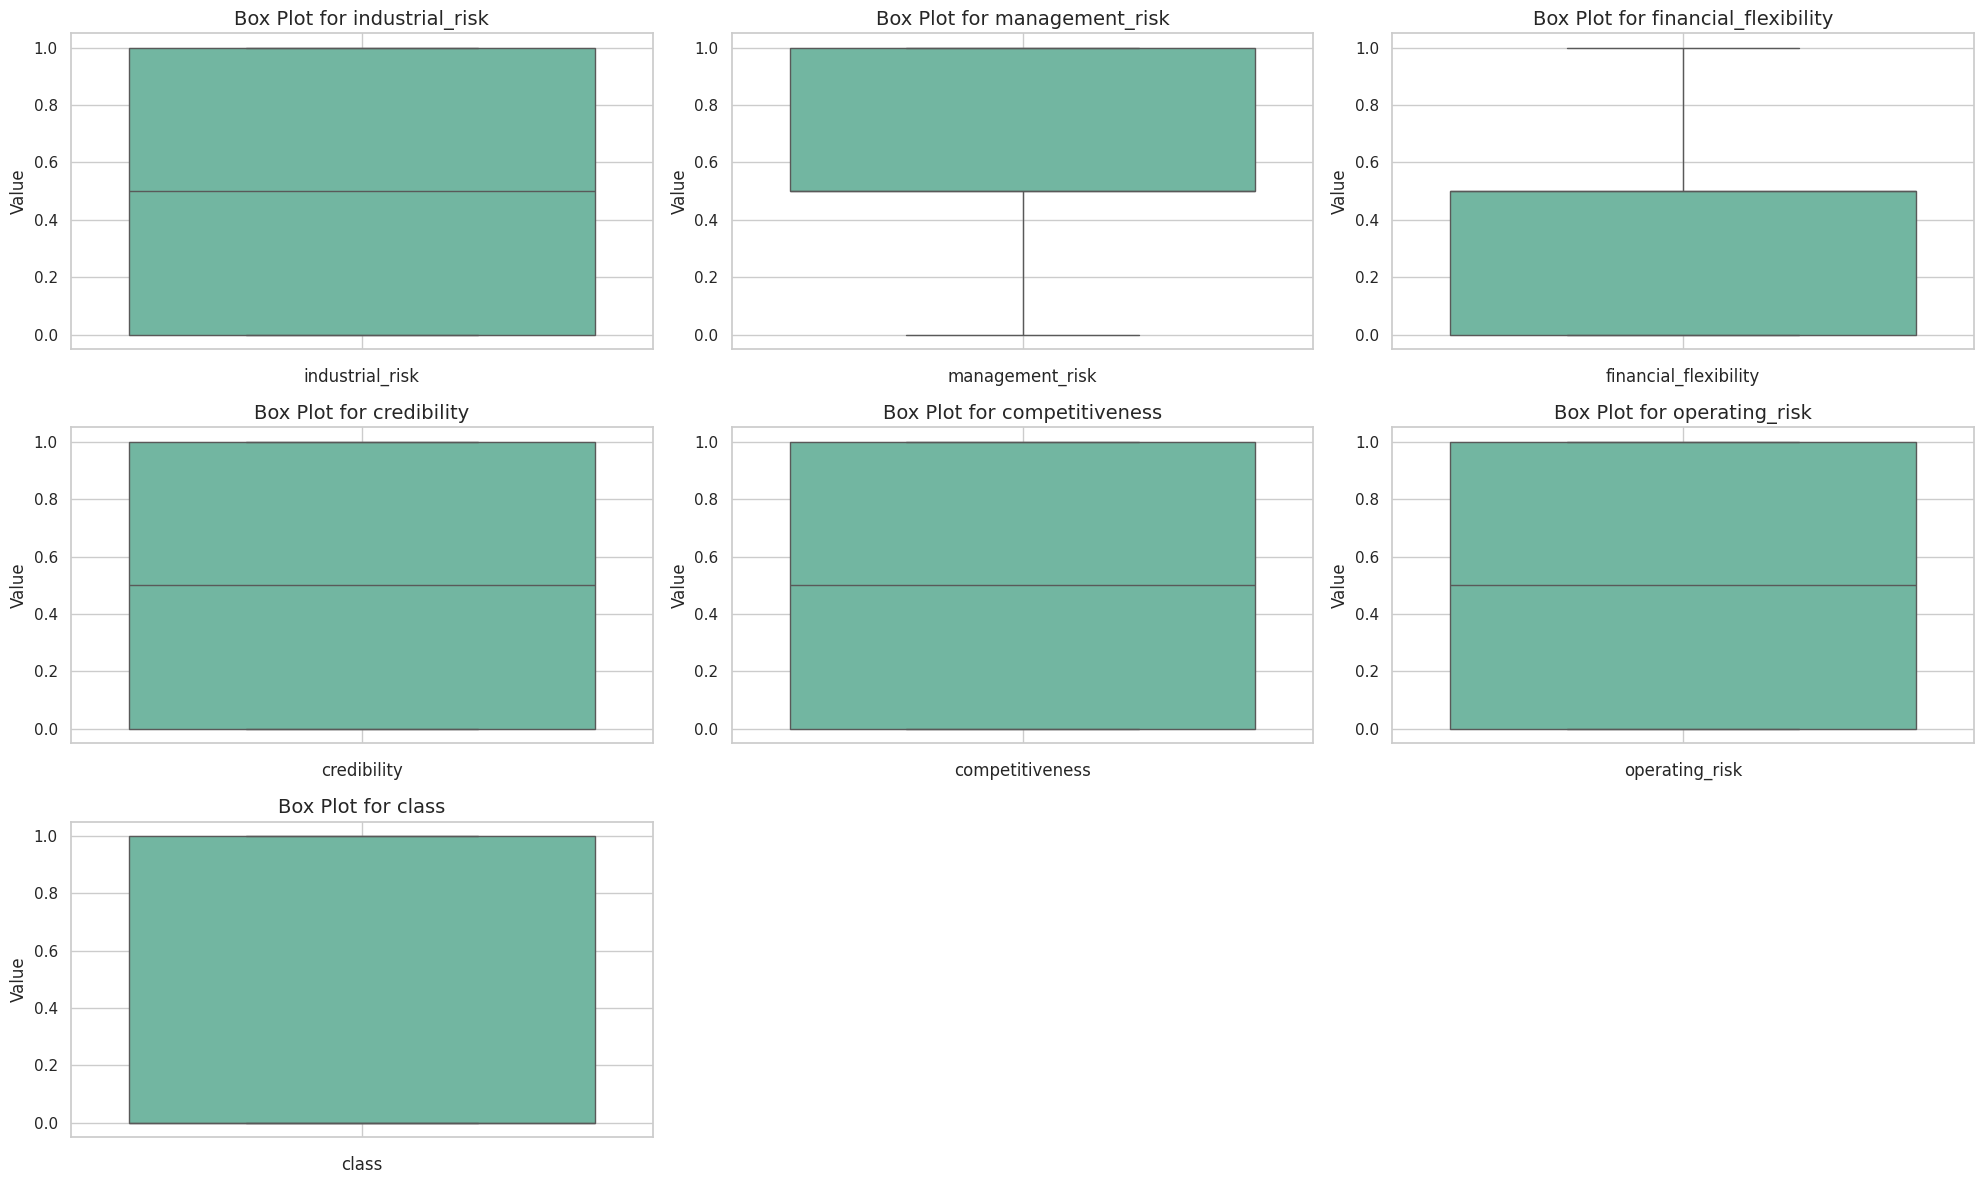

In [30]:
# Specified columns for boxplots
columns = ["industrial_risk", "management_risk", "financial_flexibility", "credibility", "competitiveness", "operating_risk","class"]

# Create a figure with a specified size
plt.figure(figsize=(20, 12))

# Generate a boxplot for each specified column
for i, column in enumerate(columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=data[column], palette="Set2")
    plt.title(f'Box Plot for {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

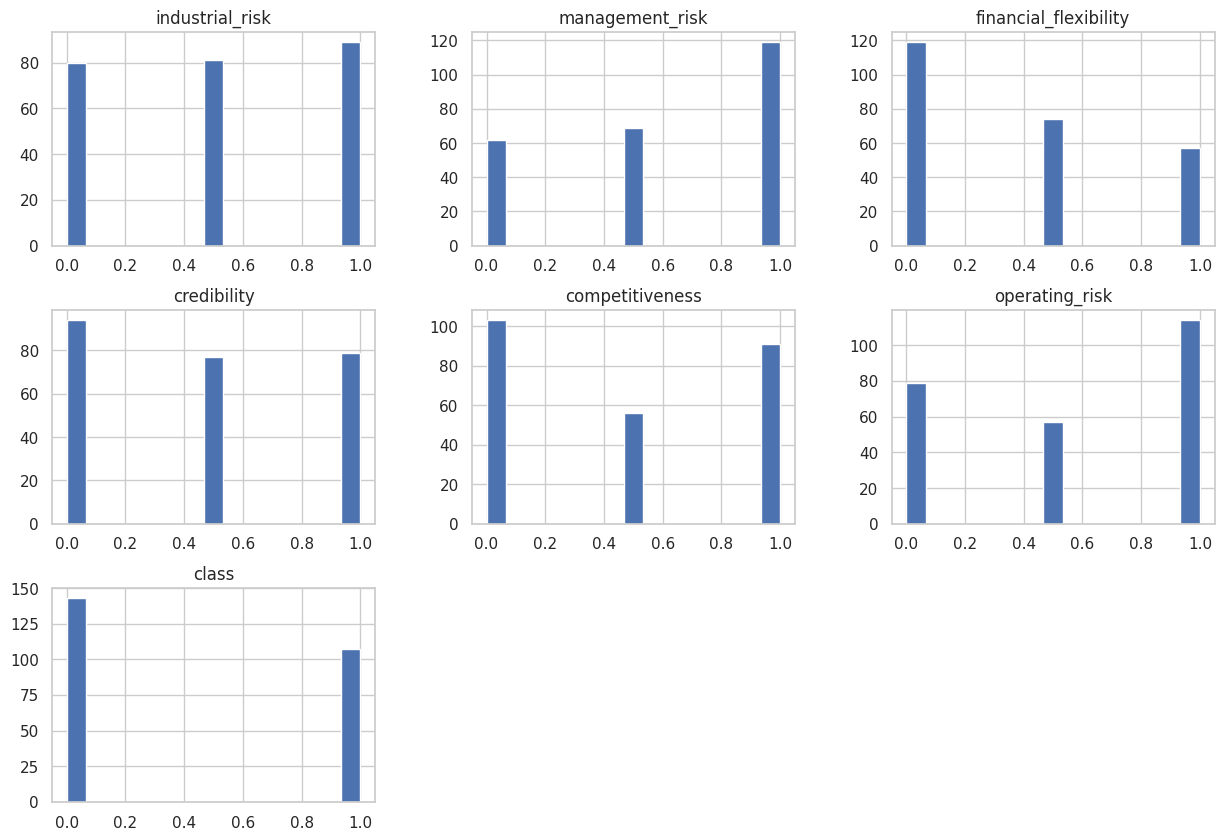

In [31]:
# Histograms for each feature
data.hist(bins=15, figsize=(15, 10))
plt.show()

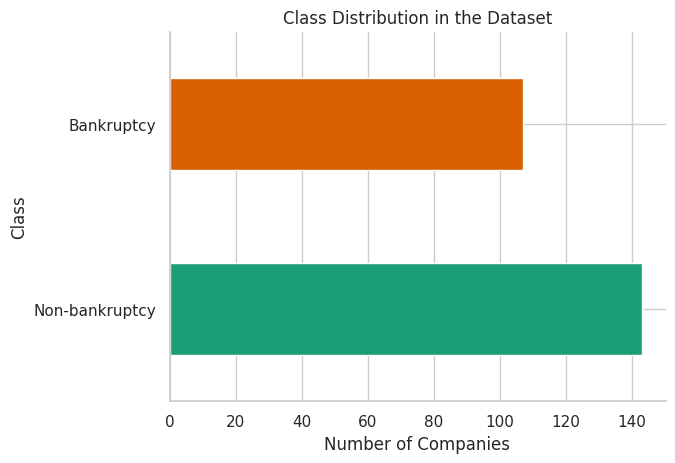

In [32]:
# Set the style for the plots
sns.set(style="whitegrid")

# Plot the class distribution
data['class'].value_counts().plot(kind='barh', color=sns.color_palette('Dark2'))

# Customize the plot
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('Number of Companies')
plt.ylabel('Class')
plt.yticks([0, 1], ['Non-bankruptcy', 'Bankruptcy'])
plt.title('Class Distribution in the Dataset')
plt.show()


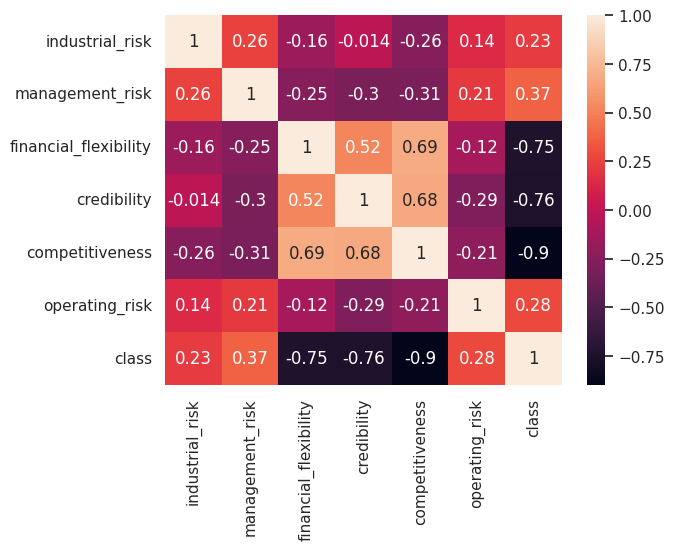

In [33]:
# Select only numerical columns for correlation calculation
numerical_data = data.select_dtypes(include=['number'])

# Create a correlation matrix
corr = numerical_data.corr()

# Generate a heatmap
sns.heatmap(corr, annot=True)
plt.show()

# **Model building and Model evaluation**

In [54]:
# Check the column names to ensure 'class' exists
print(data.columns)

Index(['industrial_risk', 'management_risk', 'financial_flexibility',
       'credibility', 'competitiveness', 'operating_risk', 'class'],
      dtype='object')


In [56]:
# Encode categorical features and target variable
label_encoder = LabelEncoder()
for column in data.columns:
    data[column] = label_encoder.fit_transform(data[column])

In [57]:
# Check the data types after encoding
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   industrial_risk        250 non-null    int64
 1   management_risk        250 non-null    int64
 2   financial_flexibility  250 non-null    int64
 3   credibility            250 non-null    int64
 4   competitiveness        250 non-null    int64
 5   operating_risk         250 non-null    int64
 6   class                  250 non-null    int64
dtypes: int64(7)
memory usage: 13.8 KB
None
   industrial_risk  management_risk  financial_flexibility  credibility  \
0                1                2                      0            0   
1                0                2                      0            0   
2                2                0                      0            0   
3                1                0                      0            1   
4                2         

In [58]:
# Split the data into features (X) and target (y)
X = data.drop('class', axis=1)
y = data['class']

In [59]:
# Check class distribution
print(y.value_counts())

class
0    143
1    107
Name: count, dtype: int64


In [62]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [64]:
# Logistic Regression / confusion_matrix / classification_report / accuracy_score / roc_auc_score

log_model = LogisticRegression(random_state=42)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
y_pred_prob_log = log_model.predict_proba(X_test)[:, 1]

print("Logistic Regression Results:")
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob_log))


Logistic Regression Results:
[[29  0]
 [ 0 21]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        21

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50

Accuracy: 1.0
ROC-AUC: 1.0


In [66]:
# Perform cross-validation for Logistic Regression
cv_scores_log = cross_val_score(log_model, X, y, cv=5, scoring='accuracy')
print(f'Logistic Regression Cross-Validation Accuracy Scores: {cv_scores_log}')
print(f'Mean Cross-Validation Accuracy: {np.mean(cv_scores_log)}')

Logistic Regression Cross-Validation Accuracy Scores: [1.   1.   1.   0.98 1.  ]
Mean Cross-Validation Accuracy: 0.9960000000000001


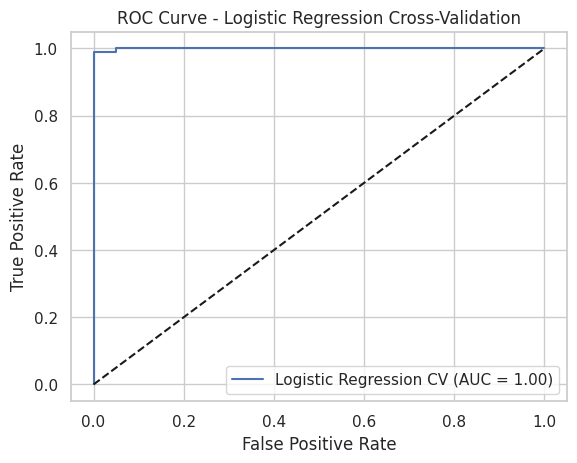

In [73]:
# Perform cross-validation and get predicted probabilities
y_pred_prob_log_cv = cross_val_predict(log_model, X, y, cv=5, method='predict_proba')[:, 1]

# Calculate ROC curve and AUC
fpr_log_cv, tpr_log_cv, _ = roc_curve(y, y_pred_prob_log_cv)
roc_auc_log_cv = roc_auc_score(y, y_pred_prob_log_cv)

# Plot ROC curve
plt.figure()
plt.plot(fpr_log_cv, tpr_log_cv, label='Logistic Regression CV (AUC = %0.2f)' % roc_auc_log_cv)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression Cross-Validation')
plt.legend(loc="lower right")
plt.show()

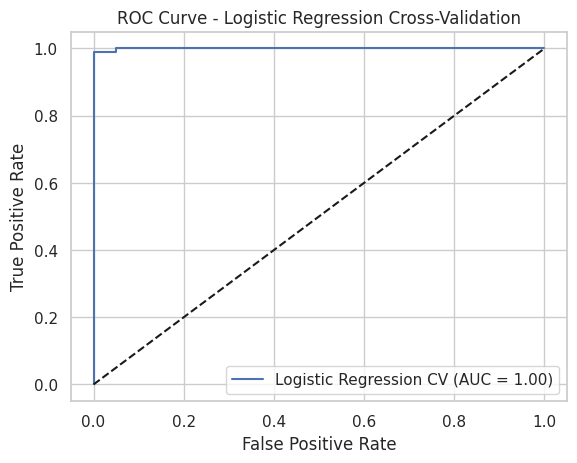

In [72]:
# ROC Curve for Logistic Regression

plt.figure()
plt.plot(fpr_log_cv, tpr_log_cv, label='Logistic Regression CV (AUC = %0.2f)' % roc_auc_log_cv)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression Cross-Validation')
plt.legend(loc="lower right")
plt.show()


In [39]:
# Decision Tree / confusion_matrix / classification_report / accuracy_score / roc_auc_score

tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)
y_pred_prob_tree = tree_model.predict_proba(X_test)[:, 1]

print("Decision Tree Results:")
print(confusion_matrix(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))
print("Accuracy:", accuracy_score(y_test, y_pred_tree))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob_tree))

Decision Tree Results:
[[28  1]
 [ 0 21]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        29
           1       0.95      1.00      0.98        21

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50

Accuracy: 0.98
ROC-AUC: 0.9827586206896552


In [48]:
# Perform cross-validation for Decision Tree

cv_scores_tree = cross_val_score(tree_model, X, y, cv=5, scoring='accuracy')
print(f'Decision Tree Cross-Validation Accuracy Scores: {cv_scores_tree}')
print(f'Mean Cross-Validation Accuracy: {np.mean(cv_scores_tree)}')

Decision Tree Cross-Validation Accuracy Scores: [1.   1.   1.   0.98 1.  ]
Mean Cross-Validation Accuracy: 0.9960000000000001


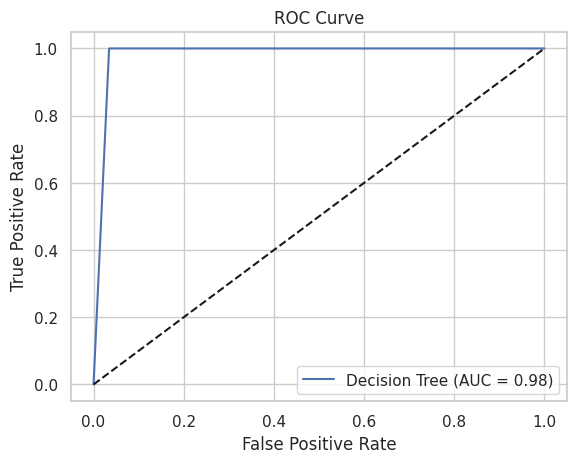

In [40]:
# ROC Curve for Decision Tree

fpr_tree, tpr_tree, _ = roc_curve(y_test, y_pred_prob_tree)
plt.figure()
plt.plot(fpr_tree, tpr_tree, label='Decision Tree (AUC = %0.2f)' % roc_auc_score(y_test, y_pred_prob_tree))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [41]:
# Random Forest / confusion_matrix / classification_report / accuracy_score / roc_auc_score

forest_model = RandomForestClassifier()
forest_model.fit(X_train, y_train)
y_pred_forest = forest_model.predict(X_test)
y_pred_prob_forest = forest_model.predict_proba(X_test)[:, 1]

print("Random Forest Results:")
print(confusion_matrix(y_test, y_pred_forest))
print(classification_report(y_test, y_pred_forest))
print("Accuracy:", accuracy_score(y_test, y_pred_forest))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob_forest))

Random Forest Results:
[[29  0]
 [ 0 21]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        21

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50

Accuracy: 1.0
ROC-AUC: 1.0


In [49]:
# Perform cross-validation for Random Forest

cv_scores_forest = cross_val_score(forest_model, X, y, cv=5, scoring='accuracy')
print(f'Random Forest Cross-Validation Accuracy Scores: {cv_scores_forest}')
print(f'Mean Cross-Validation Accuracy: {np.mean(cv_scores_forest)}')

Random Forest Cross-Validation Accuracy Scores: [1. 1. 1. 1. 1.]
Mean Cross-Validation Accuracy: 1.0


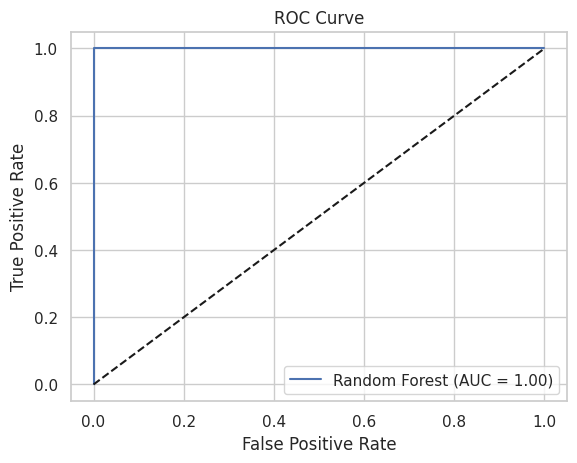

In [42]:
# ROC Curve for Random Forest

fpr_forest, tpr_forest, _ = roc_curve(y_test, y_pred_prob_forest)
plt.figure()
plt.plot(fpr_forest, tpr_forest, label='Random Forest (AUC = %0.2f)' % roc_auc_score(y_test, y_pred_prob_forest))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [81]:
# XGBoost Model / confusion_matrix / classification_report / accuracy_score / roc_auc_score

xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("XGBoost Results:")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob_xgb))

XGBoost Results:
[[28  1]
 [ 0 21]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        29
           1       0.95      1.00      0.98        21

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50

Accuracy: 0.98
ROC-AUC: 1.0


In [82]:
# Perform cross-validation for XGBoost
cv_scores_xgb = cross_val_score(xgb_model, X, y, cv=5, scoring='accuracy')
print(f'XGBoost Cross-Validation Accuracy Scores: {cv_scores_xgb}')
print(f'Mean Cross-Validation Accuracy: {np.mean(cv_scores_xgb)}')

XGBoost Cross-Validation Accuracy Scores: [1.   1.   1.   0.98 1.  ]
Mean Cross-Validation Accuracy: 0.9960000000000001


In [78]:
# Perform cross-validation and get predicted probabilities
y_pred_prob_xgb_cv = cross_val_predict(xgb_model, X, y, cv=5, method='predict_proba')[:, 1]

In [79]:
# Calculate ROC curve and AUC
fpr_xgb_cv, tpr_xgb_cv, _ = roc_curve(y, y_pred_prob_xgb_cv)
roc_auc_xgb_cv = roc_auc_score(y, y_pred_prob_xgb_cv)

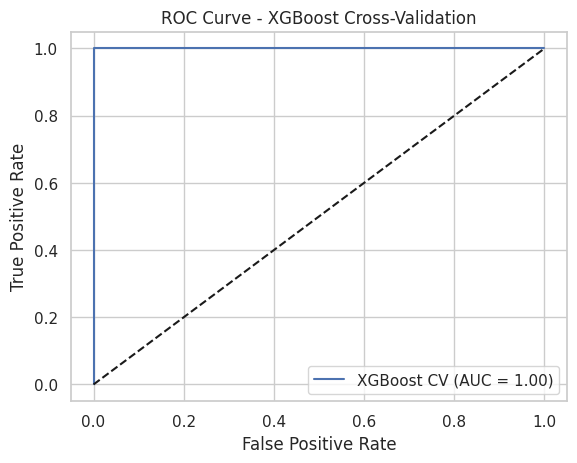

In [80]:
# Plot ROC curve
plt.figure()
plt.plot(fpr_xgb_cv, tpr_xgb_cv, label='XGBoost CV (AUC = %0.2f)' % roc_auc_xgb_cv)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost Cross-Validation')
plt.legend(loc="lower right")
plt.show()

In [76]:
# Finalization the Best model
joblib.dump(log_model, 'logistic_regression_model')
joblib.dump(tree_model, 'decision_tree_model')
joblib.dump(forest_model, 'random_forest_model')
joblib.dump(xgb_model, 'xgboost_model_model')

['xgboost_model_model']